In [ ]:
# Install required packages
!pip install tensorflow keras numpy pandas matplotlib seaborn lime shap tensorflow-addons -q
!pip install -U tf-models-official  # For EfficientNet

In [1]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


In [2]:
import cv2
import numpy as np
import random
import shutil
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from collections import defaultdict
import matplotlib.pyplot as plt
from glob import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image


In [8]:
def preprocess_image(path, size=(224, 224)):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    # Resize
    img = cv2.resize(img, size)

    # Normalization (0 to 1)
    img = img.astype(np.float32) / 255.0

    # Histogram Equalization
    img = cv2.equalizeHist((img * 255).astype(np.uint8)) / 255.0

    # Gaussian Blur
    img = cv2.GaussianBlur(img, (5, 5), 0)

    # Median Filter
    img = cv2.medianBlur((img * 255).astype(np.uint8), 3) / 255.0

    return img


In [11]:
dataset_path = "covid19-radiography-database/COVID-19_Radiography_Dataset"

categories = ['COVID', 'Normal', 'Lung_Opacity', 'Viral Pneumonia']
image_paths = []
labels = []

for label, category in enumerate(categories):
    folder = f"covid19-radiography-database/COVID-19_Radiography_Dataset/{category}/images"
    for file in os.listdir(folder):
        if file.lower().endswith(('png', 'jpg', 'jpeg')):
            image_paths.append(os.path.join(folder, file))
            labels.append(label)

print(f"Total images: {len(image_paths)}")


Total images: 21165


In [12]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.02, random_state=42)
train_idx, temp_idx = next(splitter.split(image_paths, labels))

train_paths = [image_paths[i] for i in train_idx]
train_labels = [labels[i] for i in train_idx]
temp_paths = [image_paths[i] for i in temp_idx]
temp_labels = [labels[i] for i in temp_idx]

val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
)


In [13]:
def create_meta_tasks(paths, labels, N=3, K=5, Q=5):
    data_by_class = defaultdict(list)
    for p, l in zip(paths, labels):
        data_by_class[l].append(p)

    tasks = []
    class_ids = list(data_by_class.keys())

    for _ in range(20):  # number of episodes
        selected_classes = random.sample(class_ids, N)
        label_map = {cls_id: i for i, cls_id in enumerate(selected_classes)}

        support_set = []
        query_set = []

        for cls in selected_classes:
            samples = random.sample(data_by_class[cls], K + Q)
            support_set.extend([(s, label_map[cls]) for s in samples[:K]])
            query_set.extend([(s, label_map[cls]) for s in samples[K:]])

        tasks.append((support_set, query_set))

    return tasks


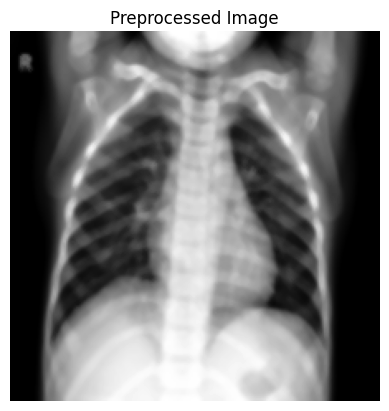

In [14]:
# Preprocess a sample image
img = preprocess_image(train_paths[45])
plt.imshow(img, cmap='gray')
plt.title("Preprocessed Image")
plt.axis('off')
plt.show()


In [15]:
class MobileNetV2Encoder(nn.Module):
    def __init__(self, output_dim=128):
        super(MobileNetV2Encoder, self).__init__()
        model = models.mobilenet_v2(pretrained=True)
        self.features = model.features
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.embedding = nn.Linear(1280, output_dim)  # MobileNetV2 last layer output: 1280

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x).view(x.size(0), -1)
        x = self.embedding(x)
        return x

class SqueezeNetEncoder(nn.Module):
    def __init__(self, output_dim=128):
        super(SqueezeNetEncoder, self).__init__()
        model = models.squeezenet1_1(pretrained=True)
        self.features = model.features
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.embedding = nn.Linear(512, output_dim)  # Final conv layer has 512 channels

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x).view(x.size(0), -1)
        x = self.embedding(x)
        return x

import timm

class EfficientNetLiteEncoder(nn.Module):
    def __init__(self, output_dim=128):
        super(EfficientNetLiteEncoder, self).__init__()
        model = timm.create_model('efficientnet_lite0', pretrained=True)
        self.features = nn.Sequential(*list(model.children())[:-1])  # remove classifier
        self.embedding = nn.Linear(model.num_features, output_dim)

    def forward(self, x):
        x = self.features(x)              # [B, C, 1, 1]
        x = x.view(x.size(0), -1)         # flatten
        x = self.embedding(x)             # [B, output_dim]
        return x


In [16]:
def euclidean_distance(a, b):
    # a: [n_query, embedding_dim]
    # b: [n_classes, embedding_dim]
    n = a.shape[0]
    m = b.shape[0]
    a = a.unsqueeze(1).expand(n, m, -1)
    b = b.unsqueeze(0).expand(n, m, -1)
    return torch.pow(a - b, 2).sum(2)


In [17]:
def compute_prototypes(support_embeddings, support_labels, n_classes):
    prototypes = []
    for cls in range(n_classes):
        cls_embeddings = support_embeddings[support_labels == cls]
        prototypes.append(cls_embeddings.mean(0))
    return torch.stack(prototypes)


In [18]:
class MetaDataset(Dataset):
    def __init__(self, episodes, transform=None):
        self.episodes = episodes
        self.transform = transform

    def __len__(self):
        return len(self.episodes)

    def __getitem__(self, idx):
        support_set, query_set = self.episodes[idx]

        def process_set(data):
            images = []
            labels = []
            for path, label in data:
                img = Image.open(path).convert('RGB')
                if self.transform:
                    img = self.transform(img)
                images.append(img)
                labels.append(label)
            return torch.stack(images), torch.tensor(labels)

        support_x, support_y = process_set(support_set)
        query_x, query_y = process_set(query_set)

        return support_x, support_y, query_x, query_y


In [19]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Simple normalization; can replace with ImageNet stats if needed
])


In [20]:
def create_meta_tasks(paths, labels, N=3, K=5, Q=5):
    data_by_class = defaultdict(list)
    for p, l in zip(paths, labels):
        data_by_class[l].append(p)

    tasks = []
    class_ids = list(data_by_class.keys())

    for _ in range(20):  # number of episodes
        selected_classes = random.sample(class_ids, N)
        label_map = {cls_id: idx for idx, cls_id in enumerate(selected_classes)}  # MAP to 0 to N-1

        support_set = []
        query_set = []

        for cls in selected_classes:
            samples = random.sample(data_by_class[cls], K + Q)
            support_set.extend([(s, label_map[cls]) for s in samples[:K]])
            query_set.extend([(s, label_map[cls]) for s in samples[K:]])

        tasks.append((support_set, query_set))

    return tasks


In [21]:
# Create episodes for meta-training
meta_train_episodes = create_meta_tasks(train_paths, train_labels, N=3, K=5, Q=5)
meta_val_episodes = create_meta_tasks(val_paths, val_labels, N=3, K=5, Q=5)
meta_test_episodes = create_meta_tasks(test_paths, test_labels, N=3, K=5, Q=5)


In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MobileNetV2Encoder_model = MobileNetV2Encoder(output_dim=128).to(device)
SqueezeNetEncoder_model = SqueezeNetEncoder(output_dim=128).to(device)
EfficientNetLiteEncoder_model = EfficientNetLiteEncoder(output_dim=128).to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 144MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and 

model.safetensors:   0%|          | 0.00/18.8M [00:00<?, ?B/s]

In [18]:
def train_prototypical(model, dataloader, optimizer, device, n_classes):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    for support_x, support_y, query_x, query_y in dataloader:
        support_x = support_x.squeeze(0).to(device)
        support_y = support_y.squeeze(0).to(device)
        query_x = query_x.squeeze(0).to(device)
        query_y = query_y.squeeze(0).to(device)

        support_embeddings = model(support_x)
        query_embeddings = model(query_x)

        prototypes = compute_prototypes(support_embeddings, support_y, n_classes)
        distances = euclidean_distance(query_embeddings, prototypes)

        loss = F.cross_entropy(-distances, query_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Calculate accuracy
        predictions = torch.argmax(-distances, dim=1)
        correct = (predictions == query_y).sum().item()
        total_correct += correct
        total_samples += query_y.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = total_correct / total_samples * 100

    return avg_loss, accuracy


In [23]:
# 🟢 MobileNetV2 (stable LR for pretrained deep net)
MobileNetV2Encoder_model_optimizer = torch.optim.Adam(
    MobileNetV2Encoder_model.parameters(), lr=0.001
)

# 🔵 SqueezeNet (very small, so use tiny LR to prevent instability)
SqueezeNetEncoder_model_optimizer = torch.optim.Adam(
    SqueezeNetEncoder_model.parameters(), lr=0.001
)

# 🟣 EfficientNet-lite (recommended lower LR for large models)
EfficientNetLiteEncoder_model_optimizer = torch.optim.Adam(
    EfficientNetLiteEncoder_model.parameters(), lr=0.001
)
from torch.optim.lr_scheduler import StepLR

# Example: reduce LR by 0.5 every 10 epochs
MobileNet_scheduler = StepLR(MobileNetV2Encoder_model_optimizer, step_size=10, gamma=0.5)
SqueezeNet_scheduler = StepLR(SqueezeNetEncoder_model_optimizer, step_size=10, gamma=0.5)
EfficientNet_scheduler = StepLR(EfficientNetLiteEncoder_model_optimizer, step_size=10, gamma=0.5)


In [20]:
import csv

# CSV File Setup
log_file = "model_training_log.csv"
with open(log_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow([
        "epoch",
        "mobilenetv2_loss", "mobilenetv2_accuracy",
        "squeezenet_loss", "squeezenet_accuracy",
        "efficientnet_loss", "efficientnet_accuracy"
    ])

In [21]:
meta_dataset = MetaDataset(meta_train_episodes, transform=transform)
meta_loader = DataLoader(meta_dataset, batch_size=1, shuffle=True)

In [22]:


# Training Loop
for epoch in range(1, 101):
    # MobileNetV2
    loss1, acc1 = train_prototypical(MobileNetV2Encoder_model, meta_loader, MobileNetV2Encoder_model_optimizer, device, n_classes=3)
    print(f"Epoch {epoch:02d} | MobileNetV2 => Loss: {loss1:.4f} | Accuracy: {acc1:.2f}%")

    # SqueezeNet
    loss2, acc2 = train_prototypical(SqueezeNetEncoder_model, meta_loader, SqueezeNetEncoder_model_optimizer, device, n_classes=3)
    print(f"Epoch {epoch:02d} | SqueezeNet  => Loss: {loss2:.4f} | Accuracy: {acc2:.2f}%")

    # EfficientNetLite
    loss3, acc3 = train_prototypical(EfficientNetLiteEncoder_model, meta_loader, EfficientNetLiteEncoder_model_optimizer, device, n_classes=3)
    print(f"Epoch {epoch:02d} | EfficientNet => Loss: {loss3:.4f} | Accuracy: {acc3:.2f}%")

    # Save to CSV
    with open(log_file, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([
            epoch,
            round(loss1, 4), round(acc1, 2),
            round(loss2, 4), round(acc2, 2),
            round(loss3, 4), round(acc3, 2)
        ])

    # Optional separator for readability
    print('-' * 60)

    # Learning rate schedulers (if defined)
    MobileNet_scheduler.step()
    SqueezeNet_scheduler.step()
    EfficientNet_scheduler.step()


Epoch 01 | MobileNetV2 => Loss: 1.8072 | Accuracy: 72.33%
Epoch 01 | SqueezeNet  => Loss: 1.4444 | Accuracy: 55.33%
Epoch 01 | EfficientNet => Loss: 0.5712 | Accuracy: 74.33%
------------------------------------------------------------
Epoch 02 | MobileNetV2 => Loss: 0.4972 | Accuracy: 83.00%
Epoch 02 | SqueezeNet  => Loss: 0.9667 | Accuracy: 58.67%
Epoch 02 | EfficientNet => Loss: 0.6938 | Accuracy: 78.33%
------------------------------------------------------------
Epoch 03 | MobileNetV2 => Loss: 0.2378 | Accuracy: 92.67%
Epoch 03 | SqueezeNet  => Loss: 0.7363 | Accuracy: 61.33%
Epoch 03 | EfficientNet => Loss: 0.3426 | Accuracy: 90.00%
------------------------------------------------------------
Epoch 04 | MobileNetV2 => Loss: 0.1229 | Accuracy: 95.67%
Epoch 04 | SqueezeNet  => Loss: 0.7261 | Accuracy: 65.00%
Epoch 04 | EfficientNet => Loss: 0.3269 | Accuracy: 90.67%
------------------------------------------------------------
Epoch 05 | MobileNetV2 => Loss: 0.1841 | Accuracy: 93.00

In [25]:
torch.save(MobileNetV2Encoder_model,'MobileNetV2Encoder_model.pth')
torch.save(SqueezeNetEncoder_model,'SqueezeNetEncoder_model.pth')
torch.save(EfficientNetLiteEncoder_model,'EfficientNetLiteEncoder_model.pth')

In [29]:

dummy_input = torch.randn(1, 3, 224, 224).to(device)
onnx_path = "MobileNetV2Encoder_model.onnx"
torch.onnx.export(MobileNetV2Encoder_model,
                      dummy_input,
                      onnx_path,
                      export_params=True,  # Export all parameters
                      opset_version=11,    # ONNX opset version
                      do_constant_folding=True, # Optimize constants
                      input_names=['input'],   # Name of the input node
                      output_names=['output'], # Name of the output node
                      dynamic_axes={'input': {0: 'batch_size'}, # Allow dynamic batch size
                                    'output': {0: 'batch_size'}})
print(f"Model saved to {onnx_path}")
onnx_path = "SqueezeNetEncoder_model.onnx"
torch.onnx.export(SqueezeNetEncoder_model,
                      dummy_input,
                      onnx_path,
                      export_params=True,  # Export all parameters
                      opset_version=11,    # ONNX opset version
                      do_constant_folding=True, # Optimize constants
                      input_names=['input'],   # Name of the input node
                      output_names=['output'], # Name of the output node
                      dynamic_axes={'input': {0: 'batch_size'}, # Allow dynamic batch size
                                    'output': {0: 'batch_size'}})
print(f"Model saved to {onnx_path}")
onnx_path = "EfficientNetLiteEncoder_model.onnx"
torch.onnx.export(EfficientNetLiteEncoder_model,
                      dummy_input,
                      onnx_path,
                      export_params=True,  # Export all parameters
                      opset_version=11,    # ONNX opset version
                      do_constant_folding=True, # Optimize constants
                      input_names=['input'],   # Name of the input node
                      output_names=['output'], # Name of the output node
                      dynamic_axes={'input': {0: 'batch_size'}, # Allow dynamic batch size
                                    'output': {0: 'batch_size'}})
print(f"Model saved to {onnx_path}")

Model saved to MobileNetV2Encoder_model.onnx
Model saved to SqueezeNetEncoder_model.onnx
Model saved to EfficientNetLiteEncoder_model.onnx


In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [33]:
def evaluate_prototypical(model, dataloader, device, n_classes):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for support_x, support_y, query_x, query_y in dataloader:
            support_x = support_x.squeeze(0).to(device)
            support_y = support_y.squeeze(0).to(device)
            query_x = query_x.squeeze(0).to(device)
            query_y = query_y.squeeze(0).to(device)

            support_embeddings = model(support_x)
            query_embeddings = model(query_x)

            prototypes = compute_prototypes(support_embeddings, support_y, n_classes)
            distances = euclidean_distance(query_embeddings, prototypes)

            probs = F.softmax(-distances, dim=1)  # Get probability scores
            preds = torch.argmax(probs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(query_y.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Convert to NumPy arrays
    y_true = np.array(all_labels)
    y_pred = np.array(all_preds)
    y_probs = np.array(all_probs)

    # Compute metrics
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average=None, zero_division=0)
    recall = recall_score(y_true, y_pred, average=None, zero_division=0)
    f1 = f1_score(y_true, y_pred, average=None, zero_division=0)

    # AUC (One-vs-rest)
    try:
        auc = roc_auc_score(y_true, y_probs, multi_class='ovr')
    except ValueError:
        auc = None  # May happen if some classes are missing

    return acc, precision, recall, f1, auc


In [33]:
meta_test_dataset = MetaDataset(meta_test_episodes, transform=transform)
meta_test_loader = DataLoader(meta_test_dataset, batch_size=1, shuffle=False)
for model in [MobileNetV2Encoder_model,SqueezeNetEncoder_model,EfficientNetLiteEncoder_model]:
    acc, precision, recall, f1, auc = evaluate_prototypical(model, meta_test_loader, device, n_classes=3)
    print('-'*50)
    print("📊 Evaluation Metrics (Test Set)")
    print(f"Accuracy: {acc*100:.2f}%")
    print(f"Precision per class: {precision}")
    print(f"Recall per class: {recall}")
    print(f"F1-score per class: {f1}")
    print(f"AUC-ROC (One-vs-Rest): {auc if auc is not None else 'Insufficient Class Coverage'}")
    print('-'*50)
    


--------------------------------------------------
📊 Evaluation Metrics (Test Set)
Accuracy: 85.00%
Precision per class: [0.79245283 0.88       0.88297872]
Recall per class: [0.84 0.88 0.83]
F1-score per class: [0.81553398 0.88       0.8556701 ]
AUC-ROC (One-vs-Rest): 0.9624083333333333
--------------------------------------------------
--------------------------------------------------
📊 Evaluation Metrics (Test Set)
Accuracy: 68.33%
Precision per class: [0.62886598 0.70588235 0.71287129]
Recall per class: [0.61 0.72 0.72]
F1-score per class: [0.61928934 0.71287129 0.71641791]
AUC-ROC (One-vs-Rest): 0.881325
--------------------------------------------------
--------------------------------------------------
📊 Evaluation Metrics (Test Set)
Accuracy: 83.00%
Precision per class: [0.77777778 0.84536082 0.87368421]
Recall per class: [0.84 0.82 0.83]
F1-score per class: [0.80769231 0.83248731 0.85128205]
AUC-ROC (One-vs-Rest): 0.9561083333333333
--------------------------------------------

  0%|          | 0/1000 [00:00<?, ?it/s]

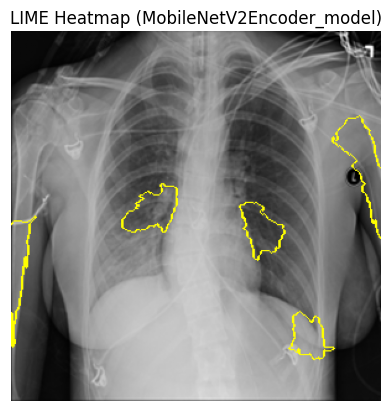

  0%|          | 0/1000 [00:00<?, ?it/s]

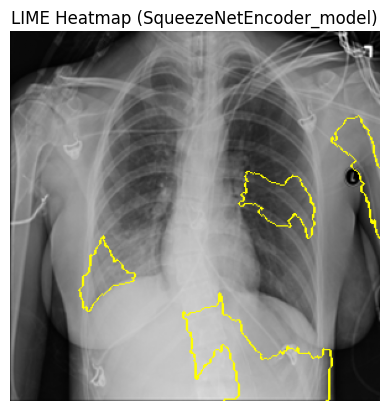

  0%|          | 0/1000 [00:00<?, ?it/s]

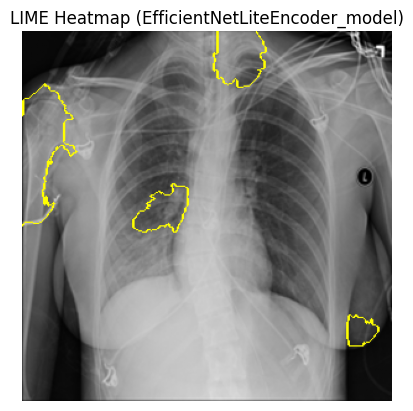

In [38]:
from lime import lime_image
import shap
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Load image
img_path, label = meta_test_episodes[0][1][2]
img = Image.open(img_path).convert("RGB")
img_tensor = transform(img).unsqueeze(0).to(device)

# Forward pass to get prediction
MobileNetV2Encoder_model.eval(),SqueezeNetEncoder_model.eval(),EfficientNetLiteEncoder_model.eval()
with torch.no_grad():
    MobileNetV2Encoder_model_embedding = MobileNetV2Encoder_model(img_tensor)
    SqueezeNetEncoder_model_embedding = SqueezeNetEncoder_model(img_tensor)
    EfficientNetLiteEncoder_model_embedding = EfficientNetLiteEncoder_model(img_tensor)
    # You can compute similarity to prototypes here if needed
    class_idx = 0  # Simulated predicted class

# --- LIME ---
explainer = lime_image.LimeImageExplainer()

def lime_predict(images):
    imgs = torch.tensor(images.transpose((0, 3, 1, 2))).float() / 255.0
    imgs = F.interpolate(imgs, size=(224, 224))
    with torch.no_grad():
        emb = MobileNetV2Encoder_model(imgs.to(device))
        logits = torch.randn(len(imgs), 3)  # Simulate 3-class score
        return logits.cpu().numpy()

lime_expl = explainer.explain_instance(np.array(img), lime_predict, top_labels=3, hide_color=0, num_samples=1000)
temp, mask = lime_expl.get_image_and_mask(class_idx, positive_only=True, num_features=5)

plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.title("LIME Heatmap (MobileNetV2Encoder_model)")
plt.axis("off")
plt.show()

def lime_predict(images):
    imgs = torch.tensor(images.transpose((0, 3, 1, 2))).float() / 255.0
    imgs = F.interpolate(imgs, size=(224, 224))
    with torch.no_grad():
        emb = SqueezeNetEncoder_model(imgs.to(device))
        logits = torch.randn(len(imgs), 3)  # Simulate 3-class score
        return logits.cpu().numpy()

lime_expl = explainer.explain_instance(np.array(img), lime_predict, top_labels=3, hide_color=0, num_samples=1000)
temp, mask = lime_expl.get_image_and_mask(class_idx, positive_only=True, num_features=5)

plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.title("LIME Heatmap (SqueezeNetEncoder_model)")
plt.axis("off")
plt.show()

def lime_predict(images):
    imgs = torch.tensor(images.transpose((0, 3, 1, 2))).float() / 255.0
    imgs = F.interpolate(imgs, size=(224, 224))
    with torch.no_grad():
        emb = EfficientNetLiteEncoder_model(imgs.to(device))
        logits = torch.randn(len(imgs), 3)  # Simulate 3-class score
        return logits.cpu().numpy()

lime_expl = explainer.explain_instance(np.array(img), lime_predict, top_labels=3, hide_color=0, num_samples=1000)
temp, mask = lime_expl.get_image_and_mask(class_idx, positive_only=True, num_features=5)

plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.title("LIME Heatmap (EfficientNetLiteEncoder_model)")
plt.axis("off")
plt.show()


In [39]:
label

0

## matching_network

In [24]:
# 🟢 MobileNetV2 (stable LR for pretrained deep net)
MobileNetV2Encoder_model_optimizer = torch.optim.Adam(
    MobileNetV2Encoder_model.parameters(), lr=0.001
)

# 🔵 SqueezeNet (very small, so use tiny LR to prevent instability)
SqueezeNetEncoder_model_optimizer = torch.optim.Adam(
    SqueezeNetEncoder_model.parameters(), lr=0.001
)

# 🟣 EfficientNet-lite (recommended lower LR for large models)
EfficientNetLiteEncoder_model_optimizer = torch.optim.Adam(
    EfficientNetLiteEncoder_model.parameters(), lr=0.001
)
from torch.optim.lr_scheduler import StepLR

# Example: reduce LR by 0.5 every 10 epochs
MobileNet_scheduler = StepLR(MobileNetV2Encoder_model_optimizer, step_size=10, gamma=0.5)
SqueezeNet_scheduler = StepLR(SqueezeNetEncoder_model_optimizer, step_size=10, gamma=0.5)
EfficientNet_scheduler = StepLR(EfficientNetLiteEncoder_model_optimizer, step_size=10, gamma=0.5)


In [29]:
import csv

# CSV File Setup
log_file = "matching_network_model_training_log.csv"
with open(log_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow([
        "epoch",
        "mobilenetv2_loss", "mobilenetv2_accuracy",
        "squeezenet_loss", "squeezenet_accuracy",
        "efficientnet_loss", "efficientnet_accuracy"
    ])

In [27]:
meta_dataset = MetaDataset(meta_train_episodes, transform=transform)
meta_loader = DataLoader(meta_dataset, batch_size=1, shuffle=True)

In [25]:
import torch
import torch.nn.functional as F

def cosine_similarity(a, b):
    a_norm = F.normalize(a, dim=1)
    b_norm = F.normalize(b, dim=1)
    return torch.matmul(a_norm, b_norm.T)

def train_matching_network(model, dataloader, optimizer, device, n_classes):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    for support_x, support_y, query_x, query_y in dataloader:
        support_x = support_x.squeeze(0).to(device)  # [K*N, C, H, W]
        support_y = support_y.squeeze(0).to(device)  # [K*N]
        query_x = query_x.squeeze(0).to(device)      # [Q, C, H, W]
        query_y = query_y.squeeze(0).to(device)      # [Q]

        # Embed support and query images using CNN
        support_embeddings = model(support_x)  # [K*N, D]
        query_embeddings = model(query_x)      # [Q, D]

        # Cosine similarity between queries and all support embeddings
        similarities = cosine_similarity(query_embeddings, support_embeddings)  # [Q, K*N]

        # Attention-based prediction
        # Step 1: Create one-hot labels for support set
        support_y_onehot = F.one_hot(support_y, num_classes=n_classes).float()  # [K*N, C]

        # Step 2: Compute attention-weighted sum of support labels
        attention = F.softmax(similarities, dim=1)  # [Q, K*N]
        preds = torch.matmul(attention, support_y_onehot)  # [Q, C]

        # Step 3: Loss (multiclass)
        loss = F.cross_entropy(preds, query_y)

        # Backward + optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track metrics
        total_loss += loss.item()
        predicted_classes = torch.argmax(preds, dim=1)
        total_correct += (predicted_classes == query_y).sum().item()
        total_samples += query_y.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = total_correct / total_samples * 100

    return avg_loss, accuracy


In [31]:


# Training Loop
for epoch in range(1, 31):
    # MobileNetV2
    loss1, acc1 = train_matching_network(MobileNetV2Encoder_model, meta_loader, MobileNetV2Encoder_model_optimizer, device, n_classes=3)
    print(f"Epoch {epoch:02d} | MobileNetV2 => Loss: {loss1:.4f} | Accuracy: {acc1:.2f}%")

    # SqueezeNet
    loss2, acc2 = train_matching_network(SqueezeNetEncoder_model, meta_loader, SqueezeNetEncoder_model_optimizer, device, n_classes=3)
    print(f"Epoch {epoch:02d} | SqueezeNet  => Loss: {loss2:.4f} | Accuracy: {acc2:.2f}%")

    # EfficientNetLite
    loss3, acc3 = train_matching_network(EfficientNetLiteEncoder_model, meta_loader, EfficientNetLiteEncoder_model_optimizer, device, n_classes=3)
    print(f"Epoch {epoch:02d} | EfficientNet => Loss: {loss3:.4f} | Accuracy: {acc3:.2f}%")

    # Save to CSV
    with open(log_file, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([
            epoch,
            round(loss1, 4), round(acc1, 2),
            round(loss2, 4), round(acc2, 2),
            round(loss3, 4), round(acc3, 2)
        ])

    # Optional separator for readability
    print('-' * 60)

    # Learning rate schedulers (if defined)
    MobileNet_scheduler.step()
    SqueezeNet_scheduler.step()
    EfficientNet_scheduler.step()


Epoch 01 | MobileNetV2 => Loss: 0.8336 | Accuracy: 93.00%
Epoch 01 | SqueezeNet  => Loss: 1.0986 | Accuracy: 41.33%
Epoch 01 | EfficientNet => Loss: 0.8089 | Accuracy: 95.33%
------------------------------------------------------------
Epoch 02 | MobileNetV2 => Loss: 0.8367 | Accuracy: 91.33%
Epoch 02 | SqueezeNet  => Loss: 1.0986 | Accuracy: 41.00%
Epoch 02 | EfficientNet => Loss: 0.8255 | Accuracy: 93.67%
------------------------------------------------------------
Epoch 03 | MobileNetV2 => Loss: 0.8405 | Accuracy: 92.67%
Epoch 03 | SqueezeNet  => Loss: 1.0986 | Accuracy: 42.00%
Epoch 03 | EfficientNet => Loss: 0.8459 | Accuracy: 88.33%
------------------------------------------------------------
Epoch 04 | MobileNetV2 => Loss: 0.8211 | Accuracy: 95.67%
Epoch 04 | SqueezeNet  => Loss: 1.0986 | Accuracy: 42.67%
Epoch 04 | EfficientNet => Loss: 0.8012 | Accuracy: 95.67%
------------------------------------------------------------
Epoch 05 | MobileNetV2 => Loss: 0.8136 | Accuracy: 94.67

In [36]:
torch.save(MobileNetV2Encoder_model,'matching_network_MobileNetV2Encoder_model.pth')
torch.save(SqueezeNetEncoder_model,'matching_network_SqueezeNetEncoder_model.pth')
torch.save(EfficientNetLiteEncoder_model,'matching_network_EfficientNetLiteEncoder_model.pth')

In [32]:

dummy_input = torch.randn(1, 3, 224, 224).to(device)
onnx_path = "matching_network_MobileNetV2Encoder_model.onnx"
torch.onnx.export(MobileNetV2Encoder_model,
                      dummy_input,
                      onnx_path,
                      export_params=True,  # Export all parameters
                      opset_version=11,    # ONNX opset version
                      do_constant_folding=True, # Optimize constants
                      input_names=['input'],   # Name of the input node
                      output_names=['output'], # Name of the output node
                      dynamic_axes={'input': {0: 'batch_size'}, # Allow dynamic batch size
                                    'output': {0: 'batch_size'}})
print(f"Model saved to {onnx_path}")
onnx_path = "matching_network_SqueezeNetEncoder_model.onnx"
torch.onnx.export(SqueezeNetEncoder_model,
                      dummy_input,
                      onnx_path,
                      export_params=True,  # Export all parameters
                      opset_version=11,    # ONNX opset version
                      do_constant_folding=True, # Optimize constants
                      input_names=['input'],   # Name of the input node
                      output_names=['output'], # Name of the output node
                      dynamic_axes={'input': {0: 'batch_size'}, # Allow dynamic batch size
                                    'output': {0: 'batch_size'}})
print(f"Model saved to {onnx_path}")
onnx_path = "matching_network_EfficientNetLiteEncoder_model.onnx"
torch.onnx.export(EfficientNetLiteEncoder_model,
                      dummy_input,
                      onnx_path,
                      export_params=True,  # Export all parameters
                      opset_version=11,    # ONNX opset version
                      do_constant_folding=True, # Optimize constants
                      input_names=['input'],   # Name of the input node
                      output_names=['output'], # Name of the output node
                      dynamic_axes={'input': {0: 'batch_size'}, # Allow dynamic batch size
                                    'output': {0: 'batch_size'}})
print(f"Model saved to {onnx_path}")

Model saved to matching_network_MobileNetV2Encoder_model.onnx
Model saved to matching_network_SqueezeNetEncoder_model.onnx
Model saved to matching_network_EfficientNetLiteEncoder_model.onnx


In [37]:
meta_test_dataset = MetaDataset(meta_test_episodes, transform=transform)
meta_test_loader = DataLoader(meta_test_dataset, batch_size=1, shuffle=False)
for model in [MobileNetV2Encoder_model,SqueezeNetEncoder_model,EfficientNetLiteEncoder_model]:
    acc, precision, recall, f1, auc = evaluate_prototypical(model, meta_test_loader, device, n_classes=3)
    print('-'*50)
    print("📊 Evaluation Metrics (Test Set)")
    print(f"Accuracy: {acc*100:.2f}%")
    print(f"Precision per class: {precision}")
    print(f"Recall per class: {recall}")
    print(f"F1-score per class: {f1}")
    print(f"AUC-ROC (One-vs-Rest): {auc if auc is not None else 'Insufficient Class Coverage'}")
    print('-'*50)
    


--------------------------------------------------
📊 Evaluation Metrics (Test Set)
Accuracy: 84.00%
Precision per class: [0.84313725 0.86458333 0.81372549]
Recall per class: [0.86 0.83 0.83]
F1-score per class: [0.85148515 0.84693878 0.82178218]
AUC-ROC (One-vs-Rest): 0.8855833333333333
--------------------------------------------------
--------------------------------------------------
📊 Evaluation Metrics (Test Set)
Accuracy: 42.33%
Precision per class: [0.43181818 0.42718447 0.41284404]
Recall per class: [0.38 0.44 0.45]
F1-score per class: [0.40425532 0.43349754 0.43062201]
AUC-ROC (One-vs-Rest): 0.5675
--------------------------------------------------
--------------------------------------------------
📊 Evaluation Metrics (Test Set)
Accuracy: 83.67%
Precision per class: [0.87096774 0.85858586 0.78703704]
Recall per class: [0.81 0.85 0.85]
F1-score per class: [0.83937824 0.85427136 0.81730769]
AUC-ROC (One-vs-Rest): 0.8884416666666667
----------------------------------------------

  0%|          | 0/1000 [00:00<?, ?it/s]

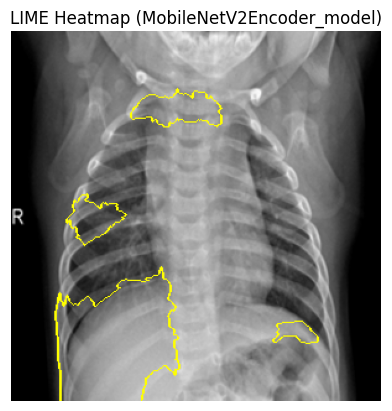

  0%|          | 0/1000 [00:00<?, ?it/s]

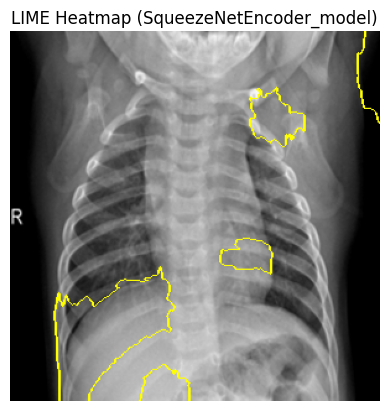

  0%|          | 0/1000 [00:00<?, ?it/s]

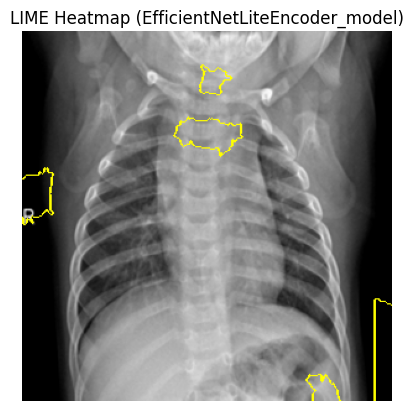

In [39]:

# Load image
img_path, label = meta_test_episodes[0][1][6]
img = Image.open(img_path).convert("RGB")
img_tensor = transform(img).unsqueeze(0).to(device)

# Forward pass to get prediction
MobileNetV2Encoder_model.eval(),SqueezeNetEncoder_model.eval(),EfficientNetLiteEncoder_model.eval()
with torch.no_grad():
    MobileNetV2Encoder_model_embedding = MobileNetV2Encoder_model(img_tensor)
    SqueezeNetEncoder_model_embedding = SqueezeNetEncoder_model(img_tensor)
    EfficientNetLiteEncoder_model_embedding = EfficientNetLiteEncoder_model(img_tensor)
    # You can compute similarity to prototypes here if needed
    class_idx = 0  # Simulated predicted class

# --- LIME ---
explainer = lime_image.LimeImageExplainer()

def lime_predict(images):
    imgs = torch.tensor(images.transpose((0, 3, 1, 2))).float() / 255.0
    imgs = F.interpolate(imgs, size=(224, 224))
    with torch.no_grad():
        emb = MobileNetV2Encoder_model(imgs.to(device))
        logits = torch.randn(len(imgs), 3)  # Simulate 3-class score
        return logits.cpu().numpy()

lime_expl = explainer.explain_instance(np.array(img), lime_predict, top_labels=3, hide_color=0, num_samples=1000)
temp, mask = lime_expl.get_image_and_mask(class_idx, positive_only=True, num_features=5)

plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.title("LIME Heatmap (MobileNetV2Encoder_model)")
plt.axis("off")
plt.show()

def lime_predict(images):
    imgs = torch.tensor(images.transpose((0, 3, 1, 2))).float() / 255.0
    imgs = F.interpolate(imgs, size=(224, 224))
    with torch.no_grad():
        emb = SqueezeNetEncoder_model(imgs.to(device))
        logits = torch.randn(len(imgs), 3)  # Simulate 3-class score
        return logits.cpu().numpy()

lime_expl = explainer.explain_instance(np.array(img), lime_predict, top_labels=3, hide_color=0, num_samples=1000)
temp, mask = lime_expl.get_image_and_mask(class_idx, positive_only=True, num_features=5)

plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.title("LIME Heatmap (SqueezeNetEncoder_model)")
plt.axis("off")
plt.show()

def lime_predict(images):
    imgs = torch.tensor(images.transpose((0, 3, 1, 2))).float() / 255.0
    imgs = F.interpolate(imgs, size=(224, 224))
    with torch.no_grad():
        emb = EfficientNetLiteEncoder_model(imgs.to(device))
        logits = torch.randn(len(imgs), 3)  # Simulate 3-class score
        return logits.cpu().numpy()

lime_expl = explainer.explain_instance(np.array(img), lime_predict, top_labels=3, hide_color=0, num_samples=1000)
temp, mask = lime_expl.get_image_and_mask(class_idx, positive_only=True, num_features=5)

plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.title("LIME Heatmap (EfficientNetLiteEncoder_model)")
plt.axis("off")
plt.show()


In [40]:
label

1